In [1]:
import seaborn as sbn
import os
import cooler
import matplotlib.pyplot as plt
import numpy as np
import cooltools
import matplotlib.colors as cl
import pandas as pd
import warnings
import bbi
import matplotlib.patches as patches
from NGS import HiCTools as HT
import matplotlib
from typing import Callable
from collections import defaultdict

# Define functions

In [2]:
def kth_diag_indices(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols

def getPairingScore(clr: cooler.Cooler, windowsize: int = 4 * 10**4,
                    func: Callable = np.mean, regions: pd.DataFrame = pd.DataFrame(),
                    norm: bool = True) -> pd.DataFrame:
    """Takes a cooler file (clr),
    a windowsize (windowsize), a summary
    function (func) and a set of genomic
    regions to calculate the pairing score
    as follows: A square with side-length windowsize
    is created for each of the entries in the supplied genomics
    regions and the summary function applied to the Hi-C pixels
    at the location in the supplied cooler file. The results are
    returned as a dataframe. If no regions are supplied, regions
    are constructed for each bin in the cooler file to
    construct a genome-wide pairing score."""
    # Check whether genomic regions were supplied
    if len(regions) == 0:
        # If no regions are supplied, pregenerate all bins; drop bins with nan weights
        regions = clr.bins()[:].dropna()
        # find midpoint of each bin to assign windows to each midpoint
        regions.loc[:, "mid"] = (regions["start"] + regions["end"])//2
    # drop nan rows from regions
    regions = regions.dropna()
    # fix indices
    regions.index = range(len(regions))
    regions.loc[:, "binID"] = range(len(regions))
    # Chromosomal arms are needed so each process only extracts a subset from the file
    arms = HT.getArmsHg19()
    # extract all windows
    windows = HT.assignRegions(windowsize, clr.binsize, regions["chrom"],
                            regions["mid"], arms)
    # add binID to later merge piles
    windows.loc[:, "binID"] = regions["binID"]
    windows = windows.dropna()
    # generate pileup
    pile = HT.doPileupICCF(clr, windows, collapse=False)
    # convert to dataframe
    pileFrame = HT.pileToFrame(pile)
    # apply function to each row (row = individual window)
    summarized = pileFrame.apply(func, axis=1)
    # subset regions with regions that were assigned windows
    output = pd.merge(regions, windows, on="binID", suffixes=("", "_w")).dropna()
    # add results
    output.loc[:, "PairingScore"] = summarized
    # normalize by median
    if norm:
        output.loc[:, "PairingScore"] = output["PairingScore"] - np.median(output.dropna()["PairingScore"])
    return output[["chrom", "start", "end", "PairingScore"]]

def recDict():
    return defaultdict(recDict)

# Supress warnings
log10(0) happens a lot

In [3]:
warnings.simplefilter("ignore")

# Define pdf style

In [4]:
matplotlib.rcParams['pdf.fonttype'] = 42

# Set Wd

In [5]:
os.chdir("/groups/gerlich/experiments/Experiments_004700/004727")

# Define colormap

In [6]:
cmapFall = cl.LinearSegmentedColormap.from_list("fall", colors=["white", "orange" ,"red", "black"], N=256)

# Define cooler filehandle

In [8]:
HICDIRS = {"CAGATC" : "/groups/gerlich/experiments/Experiments_004600/004638/Sequencing_data/Novaseq/cooler/",
"GTTTCG":"/groups/gerlich/experiments/Experiments_004600/004615/Sequencing_data/Novaseq/cooler/"}

In [9]:
BINSIZE = 500000

clrs = {rep: {interType:
        cooler.Cooler(
            os.path.join(dir, f'{rep}.{interType}.1000.mcool::/resolutions/{BINSIZE}'))
        for interType in ["cis", "trans", "all"]
        }
        for rep, dir in HICDIRS.items()}

# Chromosome 1 long arm

In [10]:
coord = "chr1:160000000-249000000"

In [11]:
examp1 = recDict()
for rep in clrs:
    for rType in ["cis", "trans", "all"]:
        examp1[rep][rType] = clrs[rep][rType].matrix(balance=True).fetch(coord)

## Plot rep1

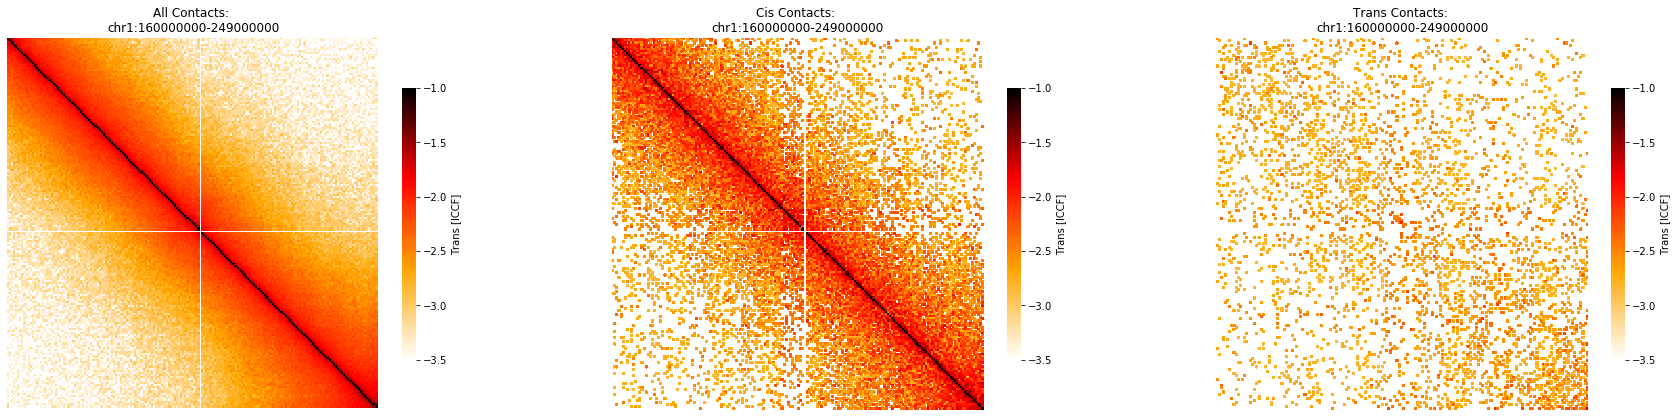

In [12]:
f, ax = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.3)
sbn.heatmap(np.log10(examp1["CAGATC"]["all"]), cmap=cmapFall, ax=ax[0], vmin=-3.5, vmax=-1,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
sbn.heatmap(np.log10(examp1["CAGATC"]["cis"]), cmap=cmapFall, ax=ax[1],  vmin=-3.5, vmax=-1,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
sbn.heatmap(np.log10(examp1["CAGATC"]["trans"]), cmap=cmapFall, ax=ax[2],  vmin=-3.5, vmax=-1,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
ax[0].set_title(f"All Contacts: \n{coord}")
ax[1].set_title(f"Cis Contacts: \n{coord}")
ax[2].set_title(f"Trans Contacts: \n{coord}")
f.set_size_inches(30, 10)
plt.show()

## Write to file

In [13]:
resultdir = "/groups/gerlich/experiments/Experiments_004700/004727/Results/Examples/"
f.savefig(os.path.join(resultdir, "Chr1_long_arm_500kb_rep1_prom.png"), bbox_inches="tight")
f.savefig(os.path.join(resultdir, "Chr1_long_arm_500kb_rep1_prom.pdf"), bbox_inches="tight")

## Plot rep2

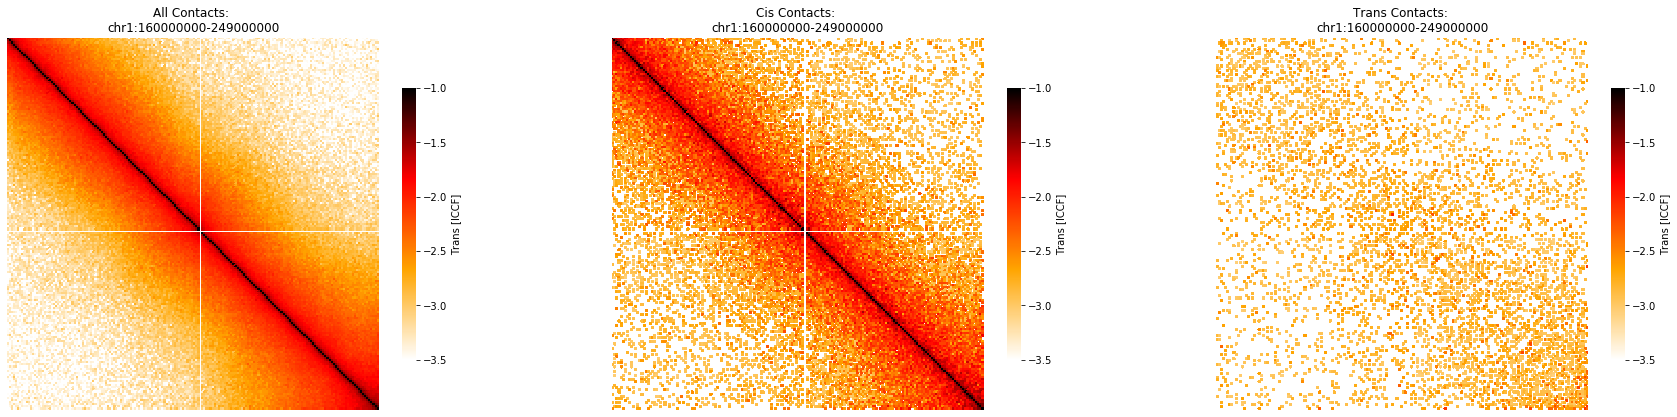

In [14]:
f, ax = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.3)
sbn.heatmap(np.log10(examp1["GTTTCG"]["all"]), cmap=cmapFall, ax=ax[0], vmin=-3.5, vmax=-1,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
sbn.heatmap(np.log10(examp1["GTTTCG"]["cis"]), cmap=cmapFall, ax=ax[1],  vmin=-3.5, vmax=-1,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
sbn.heatmap(np.log10(examp1["GTTTCG"]["trans"]), cmap=cmapFall, ax=ax[2],  vmin=-3.5, vmax=-1,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
ax[0].set_title(f"All Contacts: \n{coord}")
ax[1].set_title(f"Cis Contacts: \n{coord}")
ax[2].set_title(f"Trans Contacts: \n{coord}")
f.set_size_inches(30, 10)
plt.show()

## Write to file

In [15]:
resultdir = "/groups/gerlich/experiments/Experiments_004700/004727/Results/Examples/"
f.savefig(os.path.join(resultdir, "Chr1_long_arm_500kb_rep2_prom.png"), bbox_inches="tight")
f.savefig(os.path.join(resultdir, "Chr1_long_arm_500kb_rep2_prom.pdf"), bbox_inches="tight")